# RISEIv2 with random seeding

In [ ]:
from google.colab import drive

# drive.mount("/content/gdrive", force_remount=True)
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Install SimpleITK
!pip install SimpleITK

     |████████████████████████████████| 47.4MB 171kB/s 


In [ ]:
import tensorflow as tf

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0
Num GPUs Available:  0


In [ ]:
import os

saliencies_and_segmentations_v2_path = "/content/gdrive/My Drive/saliencies_and_segmentations_v2"

def get_path_to_saliencies_and_segmentations(sub_path):
  return os.path.join(saliencies_and_segmentations_v2_path, sub_path)

## RISEI

In [ ]:
import os
import time
import cv2

import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.restoration import inpaint

from multiprocessing import Pool

from tensorflow.keras import preprocessing

from PIL import Image

def generate_mask(params):
    grid = params['grid']
    options = params['options']
    i = params['i']
    image_data = params['image_data']

    shift_x, shift_y, shift_z = __get_random_shift(options)

    # mask has a soft corners
    mask = __get_mask(options, grid, shift_x, shift_y, shift_z)
    # binary mask does not have a soft corners and is used for an inpainting
    binary_mask = __get_binary_mask(options, grid, shift_x, shift_y, shift_z)
    
    inpaint_mask = None
    if options['b1'] > 0:
      inpaint_mask = __get_inpaint_mask(options, image_data, mask, binary_mask)
    
    new_image = __merge(options, image_data, mask, inpaint_mask)

    cache = None
    # when the debug mode is enabled
    # save the generated images to cache
    if options['debug']:
        cache = {
            'grid': grid,
            'binary_mask': binary_mask,
            'inpaint_mask': inpaint_mask,
        }

    return i, new_image, mask, cache

def __merge(options, original_image, mask, inpaint_mask):
    original_image = (original_image - original_image.min())

    # blend original image with inpaint mask if exists
    new_image = original_image

    if inpaint_mask is not None:
      if options['b1'] < 1:
        new_image = (1 - options['b1']) * original_image + options['b1'] * inpaint_mask
      else:
        new_image = inpaint_mask

    # blend original image with inpaint mask with mask
    new_image = new_image * (1 - ((1 - mask) * options['b2']))

    return new_image

def __get_inpaint_mask(options, image_data, mask, binary_mask):
    if options['inpaint'] == '3d':
        return __get_inpaint_mask_3d(options, image_data, binary_mask)
    return __get_inpaint_mask_2d(options, image_data, mask, binary_mask)


def __get_inpaint_mask_3d(options, image_data, binary_mask):
    start = time.time() 

    inverted_binary_mask = 1 - binary_mask.astype(np.uint8)
    inpainted = inpaint.inpaint_biharmonic(image_data, inverted_binary_mask, multichannel=False);
    
    end = time.time()  
    print(f"in: {end - start}")

    return inpained


def __get_inpaint_mask_2d(options, image_data, mask, binary_mask):
    start = time.time() 

    inpainted = np.zeros(image_data.shape)
    inverted_binary_mask = (1 - binary_mask).astype(np.uint8)

    for z in range(0, image_data.shape[0]):
      inpainted_z = cv2.inpaint(
          image_data[z],
          inverted_binary_mask[z],
          options['inpaint_radius'],
          options['inpaint_algorithm']
      )

      if options['inpaint_blending']:
        # inpaint with gradual blending of edges (soft edges)
        inpainted_z = image_data[z] * mask[z] + inpainted_z * (1 - mask[z])

      inpainted[z] = inpainted_z

    end = time.time()
    
    # print(f"in: {end - start}")

    return inpainted


def __get_random_shift(options):    
    shift_x = np.random.randint(0, options['over_image_size'][0])
    shift_y = np.random.randint(0, options['over_image_size'][1])
    shift_z = np.random.randint(0, options['over_image_size'][2])

    return shift_x, shift_y, shift_z


def __get_mask(options, grid, shift_x, shift_y, shift_z):
    return resize(grid,
                  options['mask_size'],
                  order=1,
                  mode='reflect',
                  anti_aliasing=False)[shift_y:shift_y + options['input_size'][0], shift_x:shift_x + options['input_size'][1], shift_z:shift_z + options['input_size'][2]]


def __get_binary_mask(options, grid, shift_x, shift_y, shift_z):
    new_grid = np.zeros(options['mask_size'])
    input_size = options['input_size']  
    start = time.time()

    for a in range(0, grid.shape[0]):
      for b in range(0, grid.shape[1]):
        for c in range(0, grid.shape[2]):
          x = a * options['cell_size'][0]
          y = b * options['cell_size'][1]
          z = c * options['cell_size'][2]

          new_grid[x:x + options['cell_size'][0], y:y + options['cell_size'][1], z:z + options['cell_size'][2]] = int(grid[a][b][c])
            
    end = time.time()
    # print(f"gbm: {end - start}")

    return new_grid[shift_x:input_size[0] + shift_x, shift_y:input_size[1] + shift_y, shift_z:input_size[2] + shift_z]


class RISEI():
    def __init__(self, input_size, **kwargs):
        self.options = {
            'input_size': input_size,
            's': kwargs.get('s', 8),  # size of the "grid" - binary mask
            'p1': kwargs.get('p1', 0.5),  # probability of cell being white - transparent
            'b1': kwargs.get('b1', 0.8),  # inpaint mask blend
            'b2': kwargs.get('b2', 0.5),  # black mask blend
            'inpaint': kwargs.get('inpaint', '2d'), # 3d, 2d
            'inpaint_radius': kwargs.get('inpaint_radius', 20),  # inpainting radius
            'inpaint_algorithm': kwargs.get('inpaint_algorithm', cv2.INPAINT_NS), # cv2.INPAINT_TELEA, cv2.INPAINT_NS
            'inpaint_blending': kwargs.get('inpaint_blending', True), # if the inpaint is gradually blended into the image
            'debug': kwargs.get('debug', False),
            'mask_size': None,
            'cell_size': None,
            'over_image_size': None,
            'processes': kwargs.get('processes', 4),
        }

        self.cache = None

        self.__get_grid_size()

    def generate_masks(self, N, image, log=True, seed=None):
        # if we are setting a new seed, save the original seed
        if seed is not None:
          st0 = np.random.get_state()
          np.random.seed(seed)

        self.__initialize_cache(N, image)

        grids = self.__get_empty_grids(N)        
        images_data = self.__get_empty_images_data(N)
        images_mask = self.__get_empty_images_data(N)
        
        params = [{ 'i': i, 'options': self.options, 'grid': grids[i], 'image_data': image } for i in range(0, N)]

        # use process pool only when more than a one process is used
        # in google colab it causes memory leaks
        if self.options['processes'] > 1:
          process_pool = Pool(processes=self.options['processes'])

          with process_pool as p:
              with tqdm(desc='Generating masks', total=N, disable=not log) as pbar:
                  for i, new_image, mask, cache in p.imap_unordered(generate_mask, params):
                      images_data[i, :, :, :] = new_image
                      images_mask[i, :, :, :] = mask

                      if cache is not None:
                          self.__save_to_cache(i, new_image, mask, cache)

                      pbar.update()
          
          process_pool.close()
        else:
          with tqdm(desc='Generating masks', total=N, disable=not log) as pbar:
            for i, new_image, mask, cache in map(generate_mask, params):
                images_data[i, :, :, :] = new_image
                images_mask[i, :, :, :] = mask

                if cache is not None:
                    self.__save_to_cache(i, new_image, mask, cache)

                pbar.update()

        # set back original random seet
        if seed is not None:
          np.random.set_state(st0)

        return images_data, images_mask

    def show_from_last_run(self, i, z, figsize=(12, 8), ncols=3, nrows=2):
        original_image = self.show_image_from_last_run(i, z)
        mask = self.show_mask_from_last_run(i, z)
        binary_mask = self.show_binary_mask_from_last_run(i, z)
        inpaint = self.show_inpaint_from_last_run(i, z) if self.options['b1'] > 0 else self.show_image_from_last_run(i, z)
        result = self.show_result_from_last_run(i, z)

        fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
        ax = axes.ravel()

        ax[0].set_title('Original')
        ax[0].imshow(original_image)

        ax[1].set_title('Binary mask')
        ax[1].imshow(binary_mask)

        ax[2].set_title('Mask')
        ax[2].imshow(mask)

        ax[3].set_title('Inpaint')
        ax[3].imshow(inpaint)

        ax[4].set_title('Result')
        ax[4].imshow(result)

        for a in ax:
            a.axis('off')

        fig.tight_layout()
        plt.show()

    def show_mask_from_last_run(self, i, z):
        mask = self.__get_from_cache('masks', i)
        _, y, x = self.options['input_size']

        image = 255 * np.ones((y, x, 3), dtype=np.uint8)
        new_image = image * mask[z, :, :].reshape(self.options['input_size'][1], self.options['input_size'][2], 1)

        return Image.fromarray(new_image.astype(np.uint8), 'RGB')

    def show_binary_mask_from_last_run(self, i, z):
        binary_mask = self.__get_from_cache('binary_masks', i)
        _, y, x = self.options['input_size']

        image = 255 * np.ones((y, x, 3), dtype=np.uint8)
        new_image = image * binary_mask[z, :, :].reshape(self.options['input_size'][1], self.options['input_size'][2], 1)

        return Image.fromarray(new_image.astype(np.uint8), 'RGB')

    def show_image_from_last_run(self, i, z):
        if self.cache == None:
            raise Exception('Cache is not defined! Initialize algorithm with debug=True')

        return self.cache['image'][z, :, :]

    def show_inpaint_from_last_run(self, i, z):
        return self.__get_from_cache('inpaint_masks', i)[z, :, :]        

    def show_result_from_last_run(self, i, z):
        return self.__get_from_cache('images_data', i)[z, :, :]

    def __get_from_cache(self, key, i):
        if self.cache == None:
            raise Exception('Cache is not defined! Initialize algorithm with debug=True')
        if len(self.cache[key]) <= i:
            raise Exception(f'Index {i} does not exist!')
        return self.cache[key][i]

    def __save_to_cache(self, i, image_data, mask, cache):
        self.cache['images_data'][i] = image_data
        self.cache['masks'][i] = mask
        self.cache['grids'][i] = cache['grid']        
        self.cache['binary_masks'][i] = cache['binary_mask']
        self.cache['inpaint_masks'][i] = cache['inpaint_mask']

    def __initialize_cache(self, N, image):
        if self.options['debug']:
            self.cache = {
                'image': image,
                'images_data': np.empty((N, *self.options['input_size'])),
                'grids': np.empty((N, self.options['s'], self.options['s'], self.options['s'])),
                'masks': np.empty((N, *self.options['input_size'])),
                'binary_masks': np.empty((N, *self.options['input_size'])),
                'inpaint_masks': np.empty((N, *self.options['input_size'])),
            }
        else:
            self.cache = None
            
    def __get_empty_grids(self, N):
        grids = np.random.rand(N, self.options['s'], self.options['s'], self.options['s']) < self.options['p1']
        return grids.astype('float32')

    def __get_empty_images_data(self, N):
        return np.empty((N, *self.options['input_size']))
    
    def __get_grid_size(self):
        # the size of one pixel (rectangle)
        cell_size = np.ceil(np.array(self.options['input_size']) / self.options['s'])

        # the additional size for each rectangle
        # since we do a crop from the mask, we
        # need to make a "bigger" mask
        # we calculate how much we need to increase the cell
        # to increase the current size by one additional cell
        over_cell_size = np.ceil((((self.options['s'] + 1) * cell_size) - (self.options['s'] * cell_size)) / self.options['s'])

        # new cell size
        new_cell_size = cell_size + over_cell_size

        # mask size (mask is larger than the image)
        mask_size = (self.options['s'] * new_cell_size).astype(np.uint32)

        # difference in size between original image and mask
        over_image_size = mask_size - self.options['input_size']    

        self.options['mask_size'] = mask_size
        self.options['cell_size'] = new_cell_size.astype(np.uint32)
        self.options['over_image_size'] = over_image_size

In [ ]:
import SimpleITK as sitk

Generating masks: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


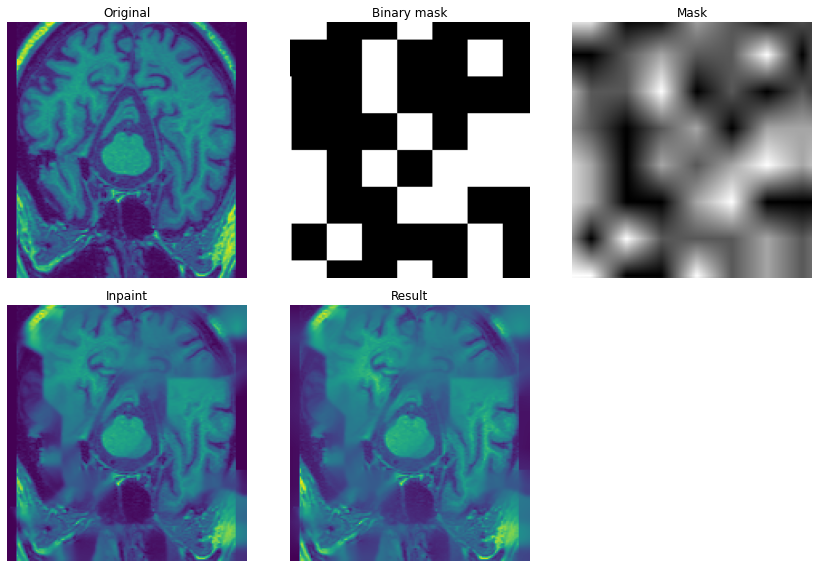

CPU times: user 4.66 s, sys: 123 ms, total: 4.78 s
Wall time: 4.7 s


In [ ]:
%%time

raw_image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))
image = sitk.GetArrayViewFromImage(raw_image)

risei = RISEI(image.shape, s=8, p1=0.5, b1=1, b2=0.5, inpaint="2d", inpaint_blending=True, inpaint_radius=5, processes=1, debug=True)

masks = risei.generate_masks(1, image, log=True, seed=420)
risei.show_from_last_run(0, 60)

Generating masks: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


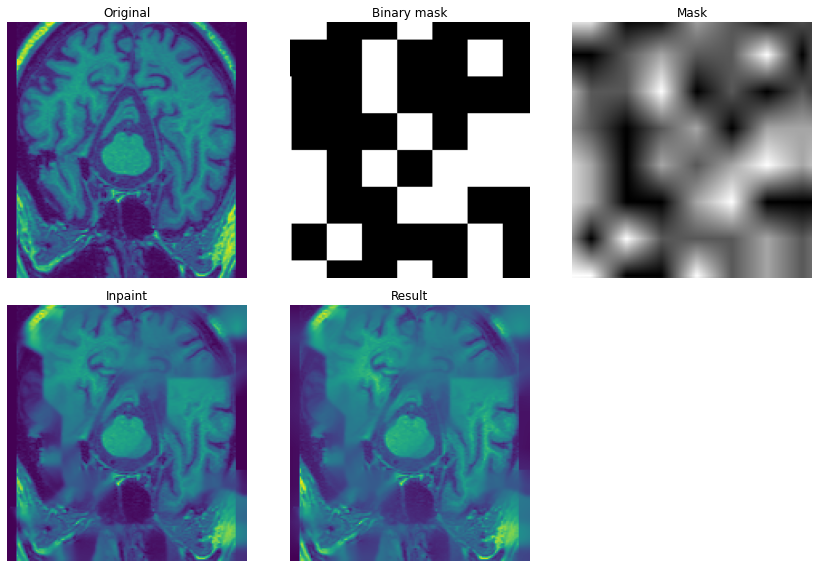

In [ ]:
masks = risei.generate_masks(1, image, log=True, seed=420)
risei.show_from_last_run(0, 60)

Generating masks: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


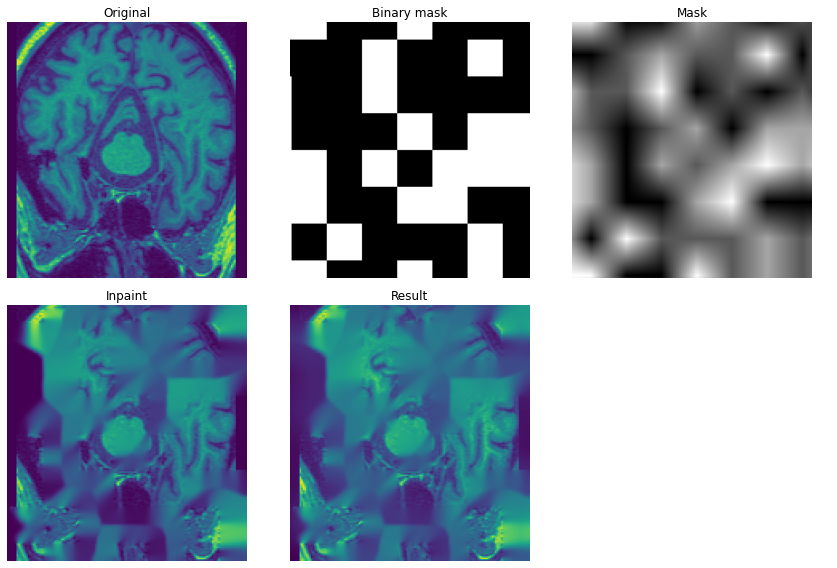

CPU times: user 4.68 s, sys: 116 ms, total: 4.79 s
Wall time: 4.72 s


In [ ]:
%%time

raw_image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))
image = sitk.GetArrayViewFromImage(raw_image)

risei = RISEI(image.shape, s=8, p1=0.5, b1=1, b2=0.5, inpaint="2d", inpaint_blending=False, inpaint_radius=5, processes=1, debug=True)

masks = risei.generate_masks(1, image, log=True, seed=420)
risei.show_from_last_run(0, 60)